<a href="https://colab.research.google.com/github/pen1064/Toronto_House_Market/blob/main/Data_Merge_TTC_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import os
from math import radians, cos, sin, asin, sqrt
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
filename = os.path.join(os.getcwd(),"subwayStations.shp")
ttcdf = gpd.read_file("subwayStations.shp")

In [6]:
ttcdf.head(4)

,STATION,LINE,PLATFORM_L,AVG_PASSEN,LINE2,PLATFORM_1,SUBWAY_TRA,ADDRESS,Opened,geometry
0,Kipling,Bloor-Danforth,1,53640,None,None,False,5247 Dundas St. West,1980,POINT (618101.613 4832636.300)
1,Islington,Bloor-Danforth,1,43090,None,None,False,3286 Bloor St. West,1968,POINT (618990.613 4833544.113)
2,Royal York,Bloor-Danforth,2,19440,None,None,False,3012 Bloor St. West,1968,POINT (620056.496 4833882.764)
3,Old Mill,Bloor-Danforth,2,5780,None,None,False,2672 Bloor St. West,1968,POINT (621361.678 4834111.901)


**Data Cleaning**\
The TTC Subway Data does not have Address, Latitude and, Longitude.\
Time to fill in the blank

In [ ]:
import googlemaps
from datetime import datetime
gmaps = googlemaps.Client(key='Your Key')

raw = []
for row, value in ttcdf.iterrows():
  print(ttcdf.loc[row, 'STATION'] + ' ttc station')
  geocode_result = gmaps.geocode(ttcdf.loc[row, 'STATION'] + " ttc station")
  raw.append(geocode_result)

Kipling ttc station
Islington ttc station
Royal York ttc station
Old Mill ttc station
Jane ttc station
Runnymede ttc station
High Park ttc station
Keele ttc station
Dundas West ttc station
Lansdowne ttc station
Dufferin ttc station
Ossington ttc station
Christie ttc station
Bathurst ttc station
Spadina ttc station
St. George ttc station
Bay ttc station
Bloor-Yonge ttc station
Sherbourne ttc station
Castle Frank ttc station
Broadview ttc station
Chester ttc station
Pape ttc station
Donlands ttc station
Greenwood ttc station
Coxwell ttc station
Woodbine ttc station
Main Street ttc station
Victoria Park ttc station
Warden ttc station
Kennedy ttc station
Union ttc station
St. Andrew ttc station
King ttc station
Osgoode ttc station
Queen ttc station
St. Patrick ttc station
Dundas ttc station
Queen's Park ttc station
College ttc station
Wellesley ttc station
Museum ttc station
Rosedale ttc station
Summerhill ttc station
St. Clair ttc station
Davisville ttc station
Eglinton ttc station
Lawren

In [ ]:
problem_stn = []
TTC_realoc = []
for ind, r in enumerate(raw):
  #print(ttcdf.loc[ind, "STATION"])
  try:
    loc = [r[0]['geometry']['location']['lat'],r[0]['geometry']['location']['lng']]
  except:
    loc = []
    problem_stn.append([ind,ttcdf.loc[ind, "STATION"] ])
  TTC_realoc.append(loc)
print(problem_stn)

[[27, 'Main Street'], [31, 'Union'], [42, 'Rosedale'], [43, 'Summerhill']]


In [ ]:
Missing_Data = [[43.689127, -79.302005], [43.64649081429354, -79.37920332061887], [43.677124989563644, -79.38884626023423], [43.682406262306756, -79.39072075838635]]
for ind, m in enumerate(problem_stn):
  TTC_realoc[m[0]] = Missing_Data[ind] 
print(TTC_realoc)

[[43.6375993, -79.53553029999999], [43.645027, -79.524574], [43.6482202, -79.511319], [43.6500958, -79.49497269999999], [43.6500102, -79.4837178], [43.651708, -79.4759444], [43.6538467, -79.4668176], [43.6554974, -79.4599095], [43.6569297, -79.4531164], [43.6590797, -79.442801], [43.6601528, -79.4356792], [43.6623565, -79.4263675], [43.6641133, -79.41836669999999], [43.6660011, -79.4112152], [43.6671711, -79.40435339999999], [43.6682821, -79.3998421], [43.6703296, -79.3899933], [43.671043, -79.38591799999999], [43.6721666, -79.3764313], [43.6736269, -79.3688482], [43.6769104, -79.3581849], [43.6782356, -79.3524545], [43.679946, -79.34481319999999], [43.6809818, -79.3378352], [43.682552, -79.330353], [43.684135, -79.32312], [43.6863715, -79.31281609999999], [43.689127, -79.302005], [43.693992, -79.2887774], [28.6478898, 180], [43.732504, -79.263632], [43.64649081429354, -79.37920332061887], [43.6476574, -79.3848079], [43.6491523, -79.37785989999999], [43.65061439999999, -79.386831399999

In [ ]:
TTC_realocdf = pd.DataFrame(TTC_realoc, columns=["lat", "long"])
ttcdf = pd.concat([ttcdf, TTC_realocdf], axis = 1)

In [ ]:
ttcdf.head(3)
ttcdf.to_excel("TTC_Stn.xlsx")

In [9]:
subwaydf = pd.read_excel("TTC_Stn.xlsx")

In [11]:
house_df = pd.read_csv("houses.csv")
house_df.head(3)

,index,title,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,full_link,full_address,lat,long,city_district,mean_district_income,district_code
0,0,"1303 - 38 Grenville St, Toronto (C4461599) | Z...",855000,870000,2 + 1 beds,2 baths,800–899 sq. ft.,1 parking,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",C4461599,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,Bay Street Corridor,56526,76
1,1,"2 Cabot Crt, Toronto (W4502992) | Zoocasa",885000,898000,3 beds,2 baths,N/A sq. ft.,6 parking,Fantastic Opportunity To Live Within The Histo...,W4502992,Semi-Detached,https://www.zoocasa.com/toronto-on-real-estate...,"2 Cabot Crt, Toronto , Ontario, Canada",43.646982,-79.530356,Islington-City Centre West,52787,14
2,2,"1504 - 30 Roehampton Ave, Toronto (C4511330) |...",550000,549900,1 beds,1 baths,500–599 sq. ft.,no parking,Bright Sunfilled Spacious 1 Bdr Unit; Floor To...,C4511330,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"30 Roehampton Ave, Toronto , Ontario, Canada",43.708472,-79.397498,Mount Pleasant West,57039,104


In [12]:
def dist_subway(list_loc, df):
    s  = []
    for i in range(len(df)):
        lon1, lon2 = radians(list_loc[1]), radians(df.loc[i, "long"])
        lat1, lat2 = radians(list_loc[0]), radians(df.loc[i, "lat"])
        
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        dist = 2 * asin(sqrt(a))*6371
        s.append([df.loc[i, "LINE"], df.loc[i,"STATION"], dist])
    s.sort(key=lambda z: z[2])
    return s[0]

subway_min = []
for ri in range(len(house_df)):
    list_loc = [house_df.loc[ri, "lat"], house_df.loc[ri,"long"]]
    subway_min.append(dist_subway(list_loc, subwaydf))

In [13]:
subway_mindf = pd.DataFrame(subway_min, columns=["Line", "Station", "Dist"])
subway_mindf.head(3)

,Line,Station,Dist
0,Yonge-University-Spadina,College,0.224219
1,Bloor-Danforth,Islington,0.513474
2,Yonge-University-Spadina,Eglinton,0.407749


In [14]:
listing_subwaydf = pd.concat([house_df,subway_mindf], axis=1)
listing_subwaydf.head(10)

,index,title,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,full_link,full_address,lat,long,city_district,mean_district_income,district_code,Line,Station,Dist
0,0,"1303 - 38 Grenville St, Toronto (C4461599) | Z...",855000,870000,2 + 1 beds,2 baths,800–899 sq. ft.,1 parking,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",C4461599,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,Bay Street Corridor,56526,76,Yonge-University-Spadina,College,0.224219
1,1,"2 Cabot Crt, Toronto (W4502992) | Zoocasa",885000,898000,3 beds,2 baths,N/A sq. ft.,6 parking,Fantastic Opportunity To Live Within The Histo...,W4502992,Semi-Detached,https://www.zoocasa.com/toronto-on-real-estate...,"2 Cabot Crt, Toronto , Ontario, Canada",43.646982,-79.530356,Islington-City Centre West,52787,14,Bloor-Danforth,Islington,0.513474
2,2,"1504 - 30 Roehampton Ave, Toronto (C4511330) |...",550000,549900,1 beds,1 baths,500–599 sq. ft.,no parking,Bright Sunfilled Spacious 1 Bdr Unit; Floor To...,C4511330,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"30 Roehampton Ave, Toronto , Ontario, Canada",43.708472,-79.397498,Mount Pleasant West,57039,104,Yonge-University-Spadina,Eglinton,0.407749
3,3,"514 - 65 East Liberty St, Toronto (C4515763) |...",665000,600000,1 + 1 beds,1 baths,600–699 sq. ft.,1 parking,Rare Loft-Like Condo In Liberty Village W/ 18'...,C4515763,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"65 East Liberty St, Toronto , Ontario, Canada",43.638399,-79.414448,Niagara,70623,82,Yonge-University-Spadina,St. Andrew,2.597742
4,4,"61 Twelfth St, Toronto (W4519375) | Zoocasa",825513,839000,2 beds,2 baths,N/A sq. ft.,1 parking,Location! Location! Location. Your Cottage In ...,W4519375,Detached,https://www.zoocasa.com/toronto-on-real-estate...,"61 Twelfth St, Toronto , Ontario, Canada",43.597096,-79.509612,New Toronto,44101,18,Bloor-Danforth,Kipling,4.963568
5,5,"505 - 4 Elsinore Path, Toronto (W4517121) | Zo...",368000,289000,0 beds,1 baths,0-499 sq. ft.,1 parking,Suite 505 Is An Immaculate Condo With The Most...,W4517121,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"4 Elsinore Path, Toronto , Ontario, Canada",43.601518,-79.510062,New Toronto,44101,18,Bloor-Danforth,Kipling,4.505456
6,6,"110 Albertus Ave, Toronto (C4467843) | Zoocasa",2700000,2798000,4 beds,5 baths,2500–3000 sq. ft.,2 parking,"Gorgeous Luxury Custom Built, 4 Bdrm Home On A...",C4467843,Detached,https://www.zoocasa.com/toronto-on-real-estate...,"110 Albertus Ave, Toronto , Ontario, Canada",43.714068,-79.403338,Lawrence Park South,169203,103,Yonge-University-Spadina,Eglinton,1.070891
7,7,"230 - 10 Eddystone Ave, Toronto (W4507649) | Z...",200000,199000,3 beds,2 baths,1000–1199 sq. ft.,1 parking,This Spacious Unit Is 3 Storeys High With 2 Ba...,W4507649,Condo Townhouse,https://www.zoocasa.com/toronto-on-real-estate...,"10 Eddystone Ave, Toronto , Ontario, Canada",43.749437,-79.516848,Glenfield-Jane Heights,27984,25,Yonge-University-Spadina,Downsview,3.076952
8,8,"182 Broadway Ave, Toronto (C4496078) | Zoocasa",975000,954900,2 beds,2 baths,1100–1500 sq. ft.,1 parking,"Location, Location, Detached Duplex In Fabulou...",C4496078,Duplex,https://www.zoocasa.com/toronto-on-real-estate...,"182 Broadway Ave, Toronto , Ontario, Canada",43.711472,-79.390394,Mount Pleasant East,85340,99,Yonge-University-Spadina,Eglinton,1.000064
9,9,"412 - 99 Blackwell Ave, Toronto (E4513033) | Z...",269900,269900,1 beds,1 baths,600–699 sq. ft.,1 parking,Excellent Location! Well-Kept Spacious 1 Bdrm ...,E4513033,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"99 Blackwell Ave, Toronto , Ontario, Canada",43.805327,-79.220229,Malvern,29573,132,Bloor-Danforth,Kennedy,8.815743


In [56]:
listing_subwaydf.to_excel("house_detail.xlsx")

CLEANING

In [76]:
listing_subwaydf = pd.read_excel("house_detail.xlsx")
listing_subwaydf.head(3)

,Unnamed: 0,index,title,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,full_link,full_address,lat,long,city_district,mean_district_income,district_code,Line,Station,Dist
0,0,0,"1303 - 38 Grenville St, Toronto (C4461599) | Z...",855000,870000,2 + 1 beds,2 baths,800–899 sq. ft.,1 parking,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",C4461599,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,Bay Street Corridor,56526,76,Yonge-University-Spadina,College,0.224219
1,1,1,"2 Cabot Crt, Toronto (W4502992) | Zoocasa",885000,898000,3 beds,2 baths,N/A sq. ft.,6 parking,Fantastic Opportunity To Live Within The Histo...,W4502992,Semi-Detached,https://www.zoocasa.com/toronto-on-real-estate...,"2 Cabot Crt, Toronto , Ontario, Canada",43.646982,-79.530356,Islington-City Centre West,52787,14,Bloor-Danforth,Islington,0.513474
2,2,2,"1504 - 30 Roehampton Ave, Toronto (C4511330) |...",550000,549900,1 beds,1 baths,500–599 sq. ft.,no parking,Bright Sunfilled Spacious 1 Bdr Unit; Floor To...,C4511330,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"30 Roehampton Ave, Toronto , Ontario, Canada",43.708472,-79.397498,Mount Pleasant West,57039,104,Yonge-University-Spadina,Eglinton,0.407749


In [77]:
listing_subwaydf.dropna(subset=["sqft", "final_price"], inplace=True)
listing_subwaydf.reset_index(drop=True, inplace=True)

Clean "sqft", "bedroom", "bathroom", "parking" data one by one

In [82]:
def clean_sqft(sqft_s):
  sqft_s = sqft_s.replace("sq. ft.","").replace("N/A", "").replace("n/a", "").strip()
  if sqft_s:
    sqft_s = re.split('–|-', sqft_s)
    if len(sqft_s) == 1:
      return int(sqft_s[0])
    elif len(sqft_s) > 1:
      return 0.5*(int(sqft_s[0]) + int(sqft_s[1]))
  else:
    return 0

listing_subwaydf.sqft = listing_subwaydf.sqft.apply(lambda z: clean_sqft(z))

In [79]:
def bedrooms_clean(bedrm_s):
  bedrm_s = bedrm_s.replace('beds', '').split('+')
  if len(bedrm_s) == 1:
      return int(bedrm_s[0])
  elif len(bedrm_s) >1:
      return int(bedrm_s[0]) + int(bedrm_s[1])
  else:
      return 0
listing_subwaydf.bedrooms = listing_subwaydf.bedrooms.apply(lambda z: bedrooms_clean(z))

In [80]:
listing_subwaydf.bathrooms = listing_subwaydf.bathrooms.apply(lambda z: int(z.replace('baths', '')))
listing_subwaydf.parking = listing_subwaydf.parking.apply(lambda z: int(re.sub('parkings|parking', '', z).replace('no', '0')))

In [94]:
listing_subwaydf["final_price_persqft"] = listing_subwaydf.apply(lambda z: z["final_price"]/z["sqft"] if z["sqft"] != 0 else np.nan, axis = 1)

In [104]:
listing_subwaydf.type.unique()
mls_type_key = ['Condo Apt', 'Condo Townhouse', 'Semi-Detached', 'Detached', 'Plex', 'Townhouse', 'Co-Op Apt']
def mls_type_clean(mls_type):
    mls_type = re.sub("Leasehold Condo|Det Condo", "Condo Apt", mls_type)
    mls_type = mls_type.replace("Co-Ownership Apt", "Co-Op Apt")
    mls_type = mls_type.replace("Att/Row/Twnhouse", "Townhouse")
    if  'plex' in mls_type:
        mls_type = "Plex"
    elif mls_type not in mls_type_key:
        mls_type = np.nan
    return mls_type
listing_subwaydf.type = listing_subwaydf.type.apply(lambda z: mls_type_clean(z))
listing_subwaydf.dropna(subset = ['type'], inplace =  True)

In [105]:
listing_subwaydf.head(3)

,Unnamed: 0,index,title,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,full_link,full_address,lat,long,city_district,mean_district_income,district_code,Line,Station,Dist,final_price_persqft
0,0,0,"1303 - 38 Grenville St, Toronto (C4461599) | Z...",855000,870000,3,2,849.5,1,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",C4461599,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,Bay Street Corridor,56526,76,Yonge-University-Spadina,College,0.224219,1006.474397
1,1,1,"2 Cabot Crt, Toronto (W4502992) | Zoocasa",885000,898000,3,2,0.0,6,Fantastic Opportunity To Live Within The Histo...,W4502992,Semi-Detached,https://www.zoocasa.com/toronto-on-real-estate...,"2 Cabot Crt, Toronto , Ontario, Canada",43.646982,-79.530356,Islington-City Centre West,52787,14,Bloor-Danforth,Islington,0.513474,NaN
2,2,2,"1504 - 30 Roehampton Ave, Toronto (C4511330) |...",550000,549900,1,1,549.5,0,Bright Sunfilled Spacious 1 Bdr Unit; Floor To...,C4511330,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"30 Roehampton Ave, Toronto , Ontario, Canada",43.708472,-79.397498,Mount Pleasant West,57039,104,Yonge-University-Spadina,Eglinton,0.407749,1000.909918


In [108]:
listing_subwaydf.to_excel("house_detail_clean.xlsx")

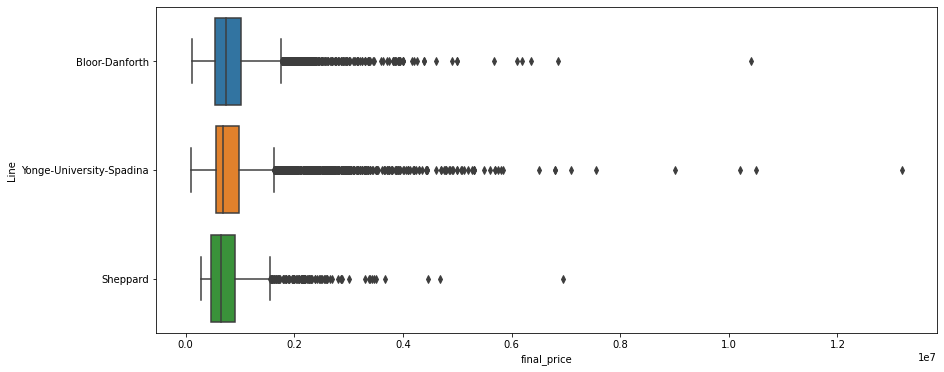

In [106]:
median = []
for key, df in listing_subwaydf.groupby(["Line"]):
    median.append((key, df["final_price"].median()))
median.sort(key= lambda z: z[1], reverse=True)
fig, ax = plt.subplots(figsize = [14,6])
sns.boxplot(y = "Line", x="final_price", data = listing_subwaydf, meanline=True, order = [a[0] for a in median])

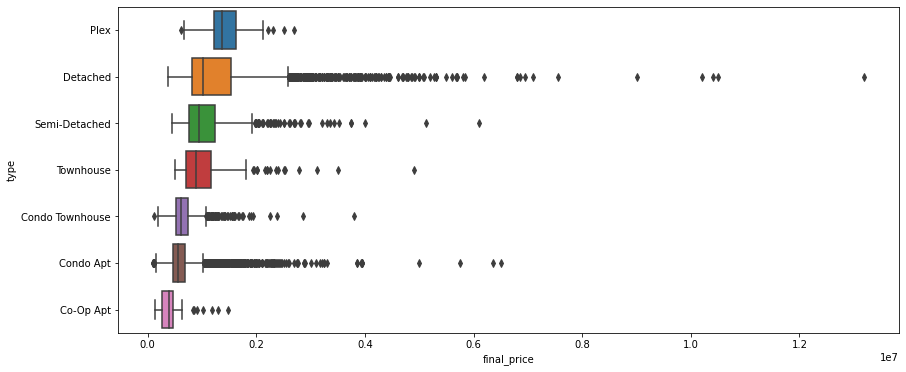

In [107]:
median = []
for key, df in listing_subwaydf.groupby(["type"]):
    median.append((key, df["final_price"].median()))
median.sort(key= lambda z: z[1], reverse=True)
fig, ax = plt.subplots(figsize = [14,6])
sns.boxplot(y = "type", x="final_price", data = listing_subwaydf, meanline=True, order = [a[0] for a in median])